# Quantum Portfolio Optimization for WISER Challenge

This notebook solves a constraint-heavy portfolio optimization problem using both classical (Gurobi) and quantum (QAOA) methods. The problem is framed as a QUBO and evaluated on key financial metrics, in line with the WISER + Vanguard project goals.

In [1]:
%pip install yfinance pandas_datareader pandas numpy matplotlib

  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached pandas_datareader-0.10.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.2-py3-none-any.whl
  Using cached curl_cffi-0.12.0-cp39-abi3-win_amd64.whl.metadata (15 kB)
  Using cached websockets-15.0.1-cp311-cp311-win_amd64.whl.metadata (7.0 kB)
  Using cached lxml-6.0.0-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
Using cached curl_cffi-0.12.0-cp39-abi3-win_amd64.whl (1.6 MB)
Using cached frozendict-2.4.6-py311-none-any.whl (16 kB)
Using cached websockets-15.0.1-cp311-cp311-win_amd64.whl (176 kB)
Using cached lxml-6.0.0-cp311-cp311-win_amd64.whl (4.0 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install --upgrade qiskit qiskit-finance qiskit-optimization qiskit-machine-learning

     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     -------- ------------------------------ 30.7/133.4 kB 1.4 MB/s eta 0:00:01
     -------------------------------------  133.1/133.4 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 133.4/133.4 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/646.5 kB ? eta -:--:--
     ------------------------------------  645.1/646.5 kB 19.8 MB/s eta 0:00:01
     ------------------------------------- 646.5/646.5 kB 13.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip show qiskit
%pip show qiskit-finance
%pip show qiskit-optimization
%pip show qiskit-machine-learning
%pip show qiskit_algorithms
%pip show qiskit_aer

Name: qiskit
Version: 1.4.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: 
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: c:\Users\Owais\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: prototype-zne, qiskit-addon-sqd, qiskit-aer, qiskit-algorithms, qiskit-finance, qiskit-ibm-runtime, qiskit-machine-learning, qiskit-optimization, qiskit-serverless
Note: you may need to restart the kernel to use updated packages.
Name: qiskit-finance
Version: 0.4.1
Summary: Qiskit Finance: A library of quantum computing finance experiments
Home-page: https://github.com/qiskit-community/qiskit-finance
Author: Qiskit Finance Development Team
Author-email: qiskit@us.ibm.com
License: Apache-2.0
Location: c:\Users\Owais\AppData\Local\Prog

In [7]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Qiskit Optimization imports
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

# Qiskit algorithm imports
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler

# Classical optimization
try:
    from gurobipy import Model, GRB
    GUROBI_AVAILABLE = True
except ImportError:
    print("Gurobi not available, will use alternative solver")
    GUROBI_AVAILABLE = False

# Other imports
from qiskit.result import QuasiDistribution

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'WMT', 'XOM']

# Download the data and handle the MultiIndex structure
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")
print("Downloaded data columns:", data.columns.tolist())

# Extract adjusted close prices
if 'Adj Close' in data.columns.levels[0]:
    df = data['Adj Close']
else:
    # Fallback to 'Close' if 'Adj Close' is not available
    df = data['Close']

print("Stock data shape:", df.shape)
print("First few rows:")
print(df.head())

# Calculate returns
returns = df.pct_change().dropna()
mu = returns.mean().values
cov = returns.cov().values
N = len(mu)

print(f"Number of assets: {N}")
print(f"Expected returns: {mu}")
print(f"Covariance matrix shape: {cov.shape}")

C:\Users\Owais\AppData\Local\Temp\ipykernel_17056\2698158459.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  10 of 10 completed

Downloaded data columns: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'GOOG'), ('Close', 'JPM'), ('Close', 'META'), ('Close', 'MSFT'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('Close', 'WMT'), ('Close', 'XOM'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'GOOG'), ('High', 'JPM'), ('High', 'META'), ('High', 'MSFT'), ('High', 'NVDA'), ('High', 'TSLA'), ('High', 'WMT'), ('High', 'XOM'), ('Low', 'AAPL'), ('Low', 'AMZN'), ('Low', 'GOOG'), ('Low', 'JPM'), ('Low', 'META'), ('Low', 'MSFT'), ('Low', 'NVDA'), ('Low', 'TSLA'), ('Low', 'WMT'), ('Low', 'XOM'), ('Open', 'AAPL'), ('Open', 'AMZN'), ('Open', 'GOOG'), ('Open', 'JPM'), ('Open', 'META'), ('Open', 'MSFT'), ('Open', 'NVDA'), ('Open', 'TSLA'), ('Open', 'WMT'), ('Open', 'XOM'), ('Volume', 'AAPL'), ('Volume', 'AMZN'), ('Volume', 'GOOG'), ('Volume', 'JPM'), ('Volume', 'META'), ('Volume', 'MSFT'), ('Volume', 'NVDA'), ('Volume', 'TSLA'), ('Volume', 'WMT'), ('Volume', 'XOM')]
Stock data shape: (756, 10)
First few rows:
Ticker           AAPL    

In [3]:
# Define benchmark ETF (e.g., QQQ)
benchmark_ticker = 'QQQ'
benchmark_data = yf.download(benchmark_ticker, start="2020-01-01", end="2023-01-01")

# Handle the benchmark data structure properly
if benchmark_data.columns.nlevels > 1:
    # Multi-level columns (when downloading single ticker, yfinance still creates MultiIndex)
    if 'Adj Close' in benchmark_data.columns.get_level_values(0):
        benchmark_prices = benchmark_data['Adj Close'].iloc[:, 0]  # Get the first (and only) column
    else:
        benchmark_prices = benchmark_data['Close'].iloc[:, 0]
else:
    # Single level columns
    if 'Adj Close' in benchmark_data.columns:
        benchmark_prices = benchmark_data['Adj Close']
    else:
        benchmark_prices = benchmark_data['Close']

# Calculate benchmark returns
benchmark_returns = benchmark_prices.pct_change().dropna()

# Create a proper Series with name for joining
benchmark_returns.name = 'Benchmark'

# Align with asset returns
data_common = returns.join(benchmark_returns, how='inner')
returns = data_common[tickers]  # re-align
benchmark_vector = data_common['Benchmark'].values

# Update expected return vector and covariance
mu = returns.mean().values
cov = returns.cov().values
N = len(mu)

# Compute benchmark mean return for tracking error calculation
mu_benchmark = benchmark_vector.mean()

print(f"Benchmark ({benchmark_ticker}) mean return: {mu_benchmark:.4f}")
print(f"Updated data shape after alignment: {returns.shape}")
print(f"Benchmark data shape: {benchmark_vector.shape}")
print(f"Benchmark data type: {type(benchmark_returns)}")
print(f"Sample benchmark returns: {benchmark_returns.head()}")

C:\Users\Owais\AppData\Local\Temp\ipykernel_17056\3249715195.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data = yf.download(benchmark_ticker, start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed

Benchmark (QQQ) mean return: 0.0005
Updated data shape after alignment: (755, 10)
Benchmark data shape: (755,)
Benchmark data type: <class 'pandas.core.series.Series'>
Sample benchmark returns: Date
2020-01-03   -0.009160
2020-01-06    0.006443
2020-01-07   -0.000139
2020-01-08    0.007516
2020-01-09    0.008473
Name: Benchmark, dtype: float64


In [4]:
# --------------------------
# Step: Define constraint parameters
# --------------------------
K = 4  # budget: total number of assets to select
R_min = 0.05  # minimum acceptable portfolio return
tech_indices = [0, 1, 2, 3, 5, 6]  # AAPL, MSFT, GOOG, AMZN, NVDA, TSLA
tech_max = 2  # max allowed tech stocks

# Penalty coefficients (tunable)
penalty_budget = 5.0
penalty_return = 5.0
penalty_sector = 5.0

In [5]:
# Classical optimization using Gurobi
if GUROBI_AVAILABLE:
    try:
        model = Model("portfolio_optimization")
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
        lambda_ = 0.5
        
        # Objective: minimize risk - maximize return
        mean_return = sum(mu[i] * x[i] for i in range(N))
        risk = sum(cov[i, j] * x[i] * x[j] for i in range(N) for j in range(N))
        model.setObjective(lambda_ * risk - (1 - lambda_) * mean_return, GRB.MINIMIZE)
        
        # Constraint: select exactly 4 assets
        model.addConstr(sum(x[i] for i in range(N)) == 4, name="budget")
        
        # Optimize
        model.optimize()
        
        # Extract results
        if model.status == GRB.OPTIMAL:
            selected_assets = [tickers[i] for i in range(N) if x[i].X > 0.5]
            gurobi_solution = [1 if x[i].X > 0.5 else 0 for i in range(N)]
            print("Gurobi optimization successful!")
            print("Selected by Gurobi:", selected_assets)
        else:
            print(f"Gurobi optimization failed with status: {model.status}")
            gurobi_solution = None
            
    except Exception as e:
        print(f"Gurobi error: {e}")
        print("This might be due to licensing issues. Continuing with quantum optimization only.")
        gurobi_solution = None
else:
    print("Gurobi not available. Skipping classical optimization.")
    gurobi_solution = None

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 PRO 4650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x04611b49
Model has 55 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:

CPU model: AMD Ryzen 5 PRO 4650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x04611b49
Model has 55 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00,

Variable types: 0 continuous, 55 integer (55 binary)

Root relaxation: objective -7.017312e-04, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

Root relaxation: objective -7.017312e-04, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00070    0    8    0.00206   -0.00070   134%     -    0s
H    0     0                       0.0016024   -0.00070   144%     -    0s
H    0     0                       0.0010772   -0.00070   165%     -    0s
H    0     0                       0.0007889   -0.00070   189%     -    0s
H    0     0                       0.0003112   -0.00070   326%     -    0s

Cutting planes:
  Zero half: 12
  RLT: 13
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00070    0    8    0.00206   -0

In [6]:
qp = QuadraticProgram()
for i in range(N):
    qp.binary_var(name=f"x{i}")
# qp.maximize(linear={f"x{i}": mu[i] for i in range(N)})
# qp2qubo = QuadraticProgramToQubo()
# qubo = qp2qubo.convert(qp)
# Initialize objective terms
linear = {f"x{i}": mu[i] for i in range(N)}
quadratic = {}

In [ ]:
# Add Tech sector penalty: limit to max_tech_assets
sector_penalty = 10.0
max_tech_assets = 2
# Define sector membership (simplified — you can generalize this mapping)
sector_map = {
    'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOG': 'Tech',
    'AMZN': 'Tech', 'META': 'Tech', 'NVDA': 'Tech',
    'TSLA': 'Auto', 'JPM': 'Finance', 'WMT': 'Retail', 'XOM': 'Energy'
}
tech_indices = [i for i, t in enumerate(tickers) if sector_map.get(t, '') == 'Tech']

# Add penalty terms: (sum x_i - max)^2
for i in tech_indices:
    linear[f"x{i}"] = linear.get(f"x{i}", 0.0) + sector_penalty
    for j in tech_indices:
        key = (f"x{i}", f"x{j}")
        quadratic[key] = quadratic.get(key, 0.0) + sector_penalty
for i in tech_indices:
    linear[f"x{i}"] -= 2 * max_tech_assets * sector_penalty

## Penalty 1

In [7]:
# Penalty 1: Budget constraint (sum(x) = K)
for i in range(N):
    linear[f"x{i}"] -= penalty_budget * (2 * K - 1)
    for j in range(i, N):
        coef = 2 * penalty_budget if i != j else penalty_budget
        key = (f"x{i}", f"x{j}")
        quadratic[key] = quadratic.get(key, 0.0) + coef

### Penalty 2: Minimum return constraint (sum(mu[i] * x[i]) >= R_min)

In [8]:
for i in range(N):
    linear[f"x{i}"] -= penalty_return * 2 * R_min * mu[i]
    for j in range(i, N):
        coef = 2 * penalty_return * mu[i] * mu[j] if i != j else penalty_return * mu[i] ** 2
        key = (f"x{i}", f"x{j}")
        quadratic[key] = quadratic.get(key, 0.0) + coef

### Penalty 3: Sector constraint (sum x_tech <= tech_max)

In [9]:
for i in tech_indices:
    linear[f"x{i}"] -= penalty_sector * (2 * tech_max - 1)
    for j in tech_indices:
        coef = 2 * penalty_sector if i != j else penalty_sector
        key = (f"x{i}", f"x{j}")
        quadratic[key] = quadratic.get(key, 0.0) + coef

### Penalty 4: Tracking Error Constraint
Minimize tracking error against benchmark (QQQ) by penalizing deviation from benchmark return.

In [10]:
# --------------------------
# Step: Add Tracking Error Penalty to QUBO
# --------------------------
# Tracking error = sum((portfolio_return - benchmark_return)^2) ~ (mu^T x - mu_b)^2

penalty_tracking = 2.0  # penalty coefficient for tracking error

for i in range(N):
    linear[f"x{i}"] += 2 * penalty_tracking * mu_benchmark * mu[i]  # encourages matching benchmark
    for j in range(i, N):
        coef = 2 * penalty_tracking * mu[i] * mu[j] if i != j else penalty_tracking * mu[i] ** 2
        key = (f"x{i}", f"x{j}")
        quadratic[key] = quadratic.get(key, 0.0) + coef

# Optional: Include print statement for debugging
print(f"Tracking error penalty applied against benchmark: {benchmark_ticker}")
print(f"Benchmark return: {mu_benchmark:.4f}")
print(f"Tracking error penalty coefficient: {penalty_tracking}")

Tracking error penalty applied against benchmark: QQQ
Benchmark return: 0.0005
Tracking error penalty coefficient: 2.0


In [11]:
# Set final QUBO objective
qp.minimize(linear=linear, quadratic=quadratic)

In [12]:
# Import required optimizer
from qiskit_algorithms.optimizers import COBYLA

# Set up QAOA with proper parameters
sampler = Sampler()
optimizer = COBYLA(maxiter=100)  # Classical optimizer for QAOA
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=1)

# Create the minimum eigen optimizer and solve the quadratic program
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)  # Use 'qp' instead of 'qubo'
print("Selected by QAOA:", result.x)

Selected by QAOA: [0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]


In [13]:
def evaluate_portfolio(x_bin, mu, cov, tickers):
    indices = [i for i, bit in enumerate(x_bin) if bit > 0.5]
    if len(indices) == 0:
        return 0, 0, []
    ret = mu[indices].sum()
    risk = cov[np.ix_(indices, indices)].sum()
    selected_tickers = [tickers[i] for i in indices]
    return ret, risk, selected_tickers

# Evaluate QAOA solution
ret_q, risk_q, selected_q = evaluate_portfolio(result.x, mu, cov, tickers)
print(f"QAOA Results:")
print(f"  Selected assets: {selected_q}")
print(f"  Expected return: {ret_q:.4f}")
print(f"  Risk (variance): {risk_q:.4f}")
print(f"  Sharpe ratio: {ret_q/np.sqrt(risk_q):.4f}" if risk_q > 0 else "  Sharpe ratio: undefined")

# Evaluate Gurobi solution if available
if 'gurobi_solution' in locals() and gurobi_solution is not None:
    ret_g, risk_g, selected_g = evaluate_portfolio(gurobi_solution, mu, cov, tickers)
    print(f"\nGurobi Results:")
    print(f"  Selected assets: {selected_g}")
    print(f"  Expected return: {ret_g:.4f}")
    print(f"  Risk (variance): {risk_g:.4f}")
    print(f"  Sharpe ratio: {ret_g/np.sqrt(risk_g):.4f}" if risk_g > 0 else "  Sharpe ratio: undefined")
else:
    print(f"\nGurobi solution not available")
    ret_g, risk_g, selected_g = None, None, None

QAOA Results:
  Selected assets: ['AMZN', 'META', 'JPM', 'WMT']
  Expected return: 0.0007
  Risk (variance): 0.0049
  Sharpe ratio: 0.0094

Gurobi Results:
  Selected assets: ['AAPL', 'TSLA', 'WMT', 'XOM']
  Expected return: 0.0056
  Risk (variance): 0.0062
  Sharpe ratio: 0.0707


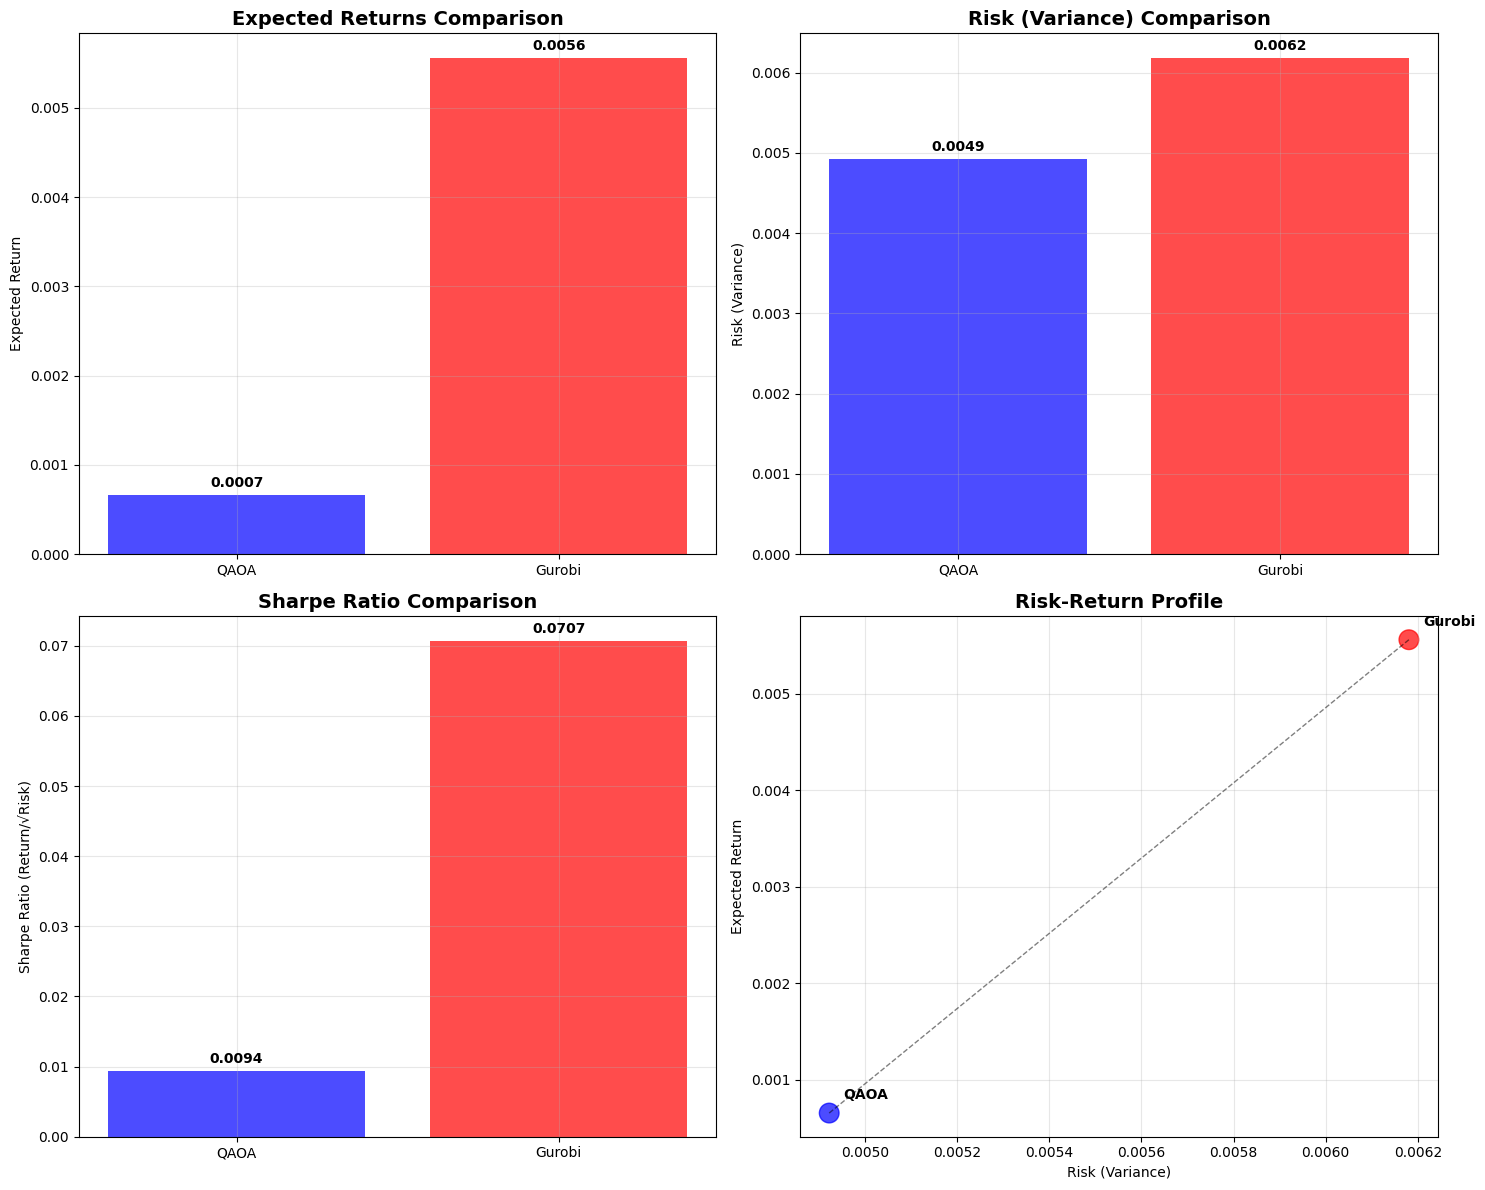


PORTFOLIO OPTIMIZATION COMPARISON SUMMARY
QAOA vs Gurobi Performance:
  Return difference: -0.0049 (-88.17%)
  Risk difference: -0.0013 (-20.37%)
  Sharpe ratio difference: -0.0613
  → Gurobi achieved better risk-adjusted returns


In [14]:
# Create comparison plots
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
methods = []
returns = []
risks = []
sharpe_ratios = []
colors = []

# QAOA results
methods.append('QAOA')
returns.append(ret_q)
risks.append(risk_q)
sharpe_ratios.append(ret_q/np.sqrt(risk_q) if risk_q > 0 else 0)
colors.append('blue')

# Gurobi results (if available)
if ret_g is not None:
    methods.append('Gurobi')
    returns.append(ret_g)
    risks.append(risk_g)
    sharpe_ratios.append(ret_g/np.sqrt(risk_g) if risk_g > 0 else 0)
    colors.append('red')

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Returns comparison
ax1.bar(methods, returns, color=colors, alpha=0.7)
ax1.set_title('Expected Returns Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Expected Return')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(returns):
    ax1.text(i, v + max(returns)*0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Risk comparison
ax2.bar(methods, risks, color=colors, alpha=0.7)
ax2.set_title('Risk (Variance) Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Risk (Variance)')
ax2.grid(True, alpha=0.3)
for i, v in enumerate(risks):
    ax2.text(i, v + max(risks)*0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Sharpe ratio comparison
ax3.bar(methods, sharpe_ratios, color=colors, alpha=0.7)
ax3.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio (Return/√Risk)')
ax3.grid(True, alpha=0.3)
for i, v in enumerate(sharpe_ratios):
    ax3.text(i, v + max(sharpe_ratios)*0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Risk-Return scatter plot
ax4.scatter(risks, returns, c=colors, s=200, alpha=0.7)
for i, method in enumerate(methods):
    ax4.annotate(method, (risks[i], returns[i]), xytext=(10, 10), 
                textcoords='offset points', fontweight='bold')
ax4.set_xlabel('Risk (Variance)')
ax4.set_ylabel('Expected Return')
ax4.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add efficient frontier line if both methods are available
if len(methods) > 1:
    # Simple line connecting the two points
    ax4.plot([risks[0], risks[1]], [returns[0], returns[1]], 'k--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# Print summary comparison
print("\n" + "="*50)
print("PORTFOLIO OPTIMIZATION COMPARISON SUMMARY")
print("="*50)
if len(methods) > 1:
    print(f"QAOA vs Gurobi Performance:")
    print(f"  Return difference: {returns[0] - returns[1]:.4f} ({((returns[0]/returns[1]-1)*100):+.2f}%)")
    print(f"  Risk difference: {risks[0] - risks[1]:.4f} ({((risks[0]/risks[1]-1)*100):+.2f}%)")
    print(f"  Sharpe ratio difference: {sharpe_ratios[0] - sharpe_ratios[1]:.4f}")
    
    # Determine which method is better
    if sharpe_ratios[0] > sharpe_ratios[1]:
        print(f"  → QAOA achieved better risk-adjusted returns")
    elif sharpe_ratios[1] > sharpe_ratios[0]:
        print(f"  → Gurobi achieved better risk-adjusted returns")
    else:
        print(f"  → Both methods achieved similar risk-adjusted returns")
else:
    print(f"Only QAOA results available:")
    print(f"  Selected {len(selected_q)} assets: {selected_q}")
    print(f"  Achieved return: {ret_q:.4f}")
    print(f"  Risk level: {risk_q:.4f}")
    print(f"  Sharpe ratio: {sharpe_ratios[0]:.4f}")

Returns type: <class 'list'>
Returns shape: No shape attribute
Returns columns: No columns
Benchmark vector shape: (755,)
Number of tickers: 10
Using returns matrix shape: (755, 10)
QAOA selected indices: [3, 4, 7, 8]
QAOA selected assets: ['AMZN', 'META', 'JPM', 'WMT']
QAOA portfolio returns sample: [-0.00986367  0.00772196 -0.00550243  0.00167465  0.00827299]
Gurobi selected indices: [0, 6, 8, 9]
Gurobi selected assets: ['AAPL', 'TSLA', 'WMT', 'XOM']


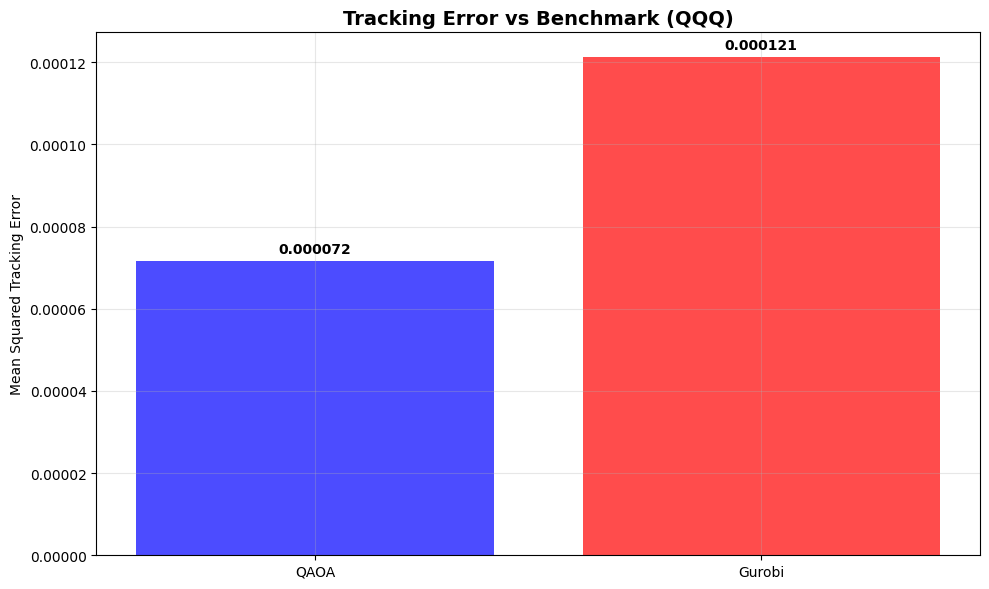


TRACKING ERROR ANALYSIS
Benchmark: QQQ
QAOA Tracking Error: 0.000072
Gurobi Tracking Error: 0.000121
Tracking Error Difference: -0.000049
→ QAOA has lower tracking error (better benchmark tracking)


In [17]:
# Tracking error visualization
fig, ax = plt.subplots(figsize=(10, 6))

te_values = []
te_labels = []

# Debug the data structures
print(f"Returns type: {type(returns)}")
print(f"Returns shape: {returns.shape if hasattr(returns, 'shape') else 'No shape attribute'}")
print(f"Returns columns: {returns.columns.tolist() if hasattr(returns, 'columns') else 'No columns'}")
print(f"Benchmark vector shape: {benchmark_vector.shape}")
print(f"Number of tickers: {len(tickers)}")

# Ensure we have the proper returns matrix for portfolio calculations
# Use the original returns calculation from the individual assets
if hasattr(returns, 'values') and returns.shape[1] == len(tickers):
    returns_matrix = returns.values  # Shape should be (n_periods, n_assets)
else:
    # Reconstruct from data_common if needed
    if 'data_common' in locals():
        returns_matrix = data_common[tickers].values
    else:
        print("Error: Cannot find proper returns matrix for tracking error calculation")
        print("Please re-run the benchmark loading cell to fix data alignment")
        returns_matrix = None

if returns_matrix is not None:
    print(f"Using returns matrix shape: {returns_matrix.shape}")
    
    # QAOA tracking error
    # Get selected assets and calculate equal-weighted portfolio returns
    selected_indices = [i for i, x in enumerate(result.x) if x > 0.5]
    print(f"QAOA selected indices: {selected_indices}")
    
    if len(selected_indices) > 0:
        # Calculate equally weighted portfolio returns for selected assets
        portfolio_returns_qaoa = returns_matrix[:, selected_indices].mean(axis=1)
        tracking_error_q = np.mean((portfolio_returns_qaoa - benchmark_vector) ** 2)
        te_values.append(tracking_error_q)
        te_labels.append('QAOA')
        
        print(f"QAOA selected assets: {[tickers[i] for i in selected_indices]}")
        print(f"QAOA portfolio returns sample: {portfolio_returns_qaoa[:5]}")
    else:
        print("Warning: No assets selected by QAOA")
        tracking_error_q = np.inf
        te_values.append(tracking_error_q)
        te_labels.append('QAOA')

    # Gurobi tracking error (if available)
    if gurobi_solution is not None:
        selected_indices_g = [i for i, x in enumerate(gurobi_solution) if x > 0.5]
        print(f"Gurobi selected indices: {selected_indices_g}")
        
        if len(selected_indices_g) > 0:
            portfolio_returns_gurobi = returns_matrix[:, selected_indices_g].mean(axis=1)
            tracking_error_g = np.mean((portfolio_returns_gurobi - benchmark_vector) ** 2)
            te_values.append(tracking_error_g)
            te_labels.append('Gurobi')
            
            print(f"Gurobi selected assets: {[tickers[i] for i in selected_indices_g]}")
        else:
            print("Warning: No assets selected by Gurobi")
            tracking_error_g = np.inf
            te_values.append(tracking_error_g)
            te_labels.append('Gurobi')

    # Plot the results
    # Handle infinite values for plotting
    plot_values = [min(val, 1.0) if val != np.inf else 1.0 for val in te_values]
    
    ax.bar(te_labels, plot_values, color=['blue', 'red'][:len(te_values)], alpha=0.7)
    ax.set_title('Tracking Error vs Benchmark (QQQ)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Squared Tracking Error')
    ax.grid(True, alpha=0.3)

    for i, (val, plot_val) in enumerate(zip(te_values, plot_values)):
        if val == np.inf:
            ax.text(i, plot_val + max(plot_values) * 0.01, 'No Selection', ha='center', va='bottom', fontweight='bold')
        else:
            ax.text(i, plot_val + max(plot_values) * 0.01, f'{val:.6f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print tracking error comparison
    print("\n" + "="*50)
    print("TRACKING ERROR ANALYSIS")
    print("="*50)
    print(f"Benchmark: {benchmark_ticker}")
    print(f"QAOA Tracking Error: {tracking_error_q:.6f}" if tracking_error_q != np.inf else "QAOA Tracking Error: No assets selected")
    
    if len(te_values) > 1:
        if tracking_error_g != np.inf:
            print(f"Gurobi Tracking Error: {tracking_error_g:.6f}")
            if tracking_error_q != np.inf:
                print(f"Tracking Error Difference: {tracking_error_q - tracking_error_g:.6f}")
                if tracking_error_q < tracking_error_g:
                    print("→ QAOA has lower tracking error (better benchmark tracking)")
                else:
                    print("→ Gurobi has lower tracking error (better benchmark tracking)")
        else:
            print("Gurobi Tracking Error: No assets selected")
    else:
        print("→ Only QAOA tracking error available")
else:
    print("Cannot calculate tracking error - returns data structure issue")

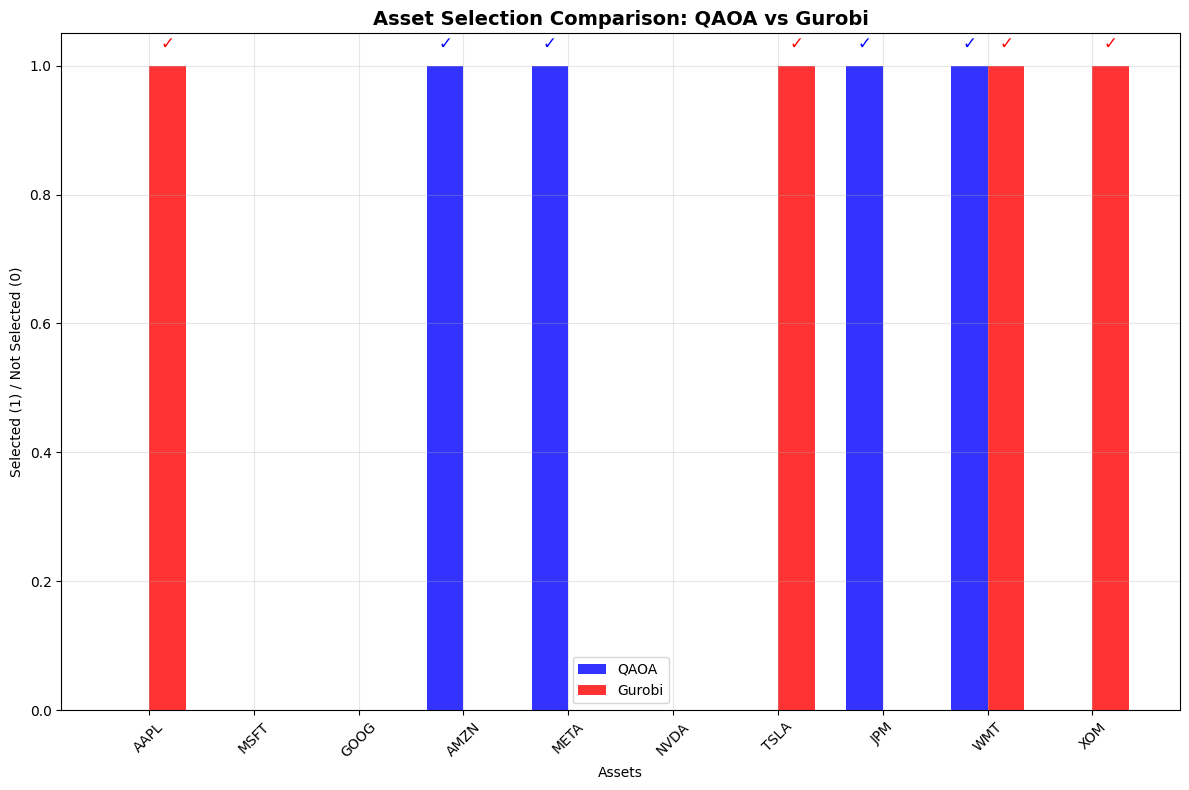


DETAILED ASSET SELECTION ANALYSIS

Individual Asset Statistics:
Ticker  Expected Return  Risk (Variance)  Return/Risk Ratio
  AAPL           0.0010           0.0005             1.8915
  MSFT           0.0008           0.0005             1.6858
  GOOG           0.0006           0.0005             1.2366
  AMZN           0.0001           0.0006             0.2328
  META          -0.0002           0.0009            -0.2638
  NVDA           0.0018           0.0012             1.4523
  TSLA           0.0030           0.0021             1.4336
   JPM           0.0003           0.0006             0.5923
   WMT           0.0004           0.0003             1.6277
   XOM           0.0011           0.0006             1.7589

QAOA Selected Assets: ['AMZN', 'META', 'JPM', 'WMT']
Gurobi Selected Assets: ['AAPL', 'TSLA', 'WMT', 'XOM']

Selection Overlap Analysis:
  Common selections: ['WMT']
  QAOA only: ['META', 'JPM', 'AMZN']
  Gurobi only: ['AAPL', 'TSLA', 'XOM']
  Agreement rate: 14.3%


In [18]:
# Visualize selected assets comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create a comparison of selected assets
asset_comparison = pd.DataFrame(index=tickers)
asset_comparison['QAOA'] = [1 if ticker in selected_q else 0 for ticker in tickers]

if selected_g is not None:
    asset_comparison['Gurobi'] = [1 if ticker in selected_g else 0 for ticker in tickers]
    
    # Create side-by-side bar chart
    x = np.arange(len(tickers))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, asset_comparison['QAOA'], width, label='QAOA', alpha=0.8, color='blue')
    bars2 = ax.bar(x + width/2, asset_comparison['Gurobi'], width, label='Gurobi', alpha=0.8, color='red')
    
    ax.set_xlabel('Assets')
    ax.set_ylabel('Selected (1) / Not Selected (0)')
    ax.set_title('Asset Selection Comparison: QAOA vs Gurobi', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(tickers, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, '✓', 
                   ha='center', va='bottom', fontweight='bold', color='blue', fontsize=12)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, '✓', 
                   ha='center', va='bottom', fontweight='bold', color='red', fontsize=12)
            
else:
    # Only QAOA results available
    bars = ax.bar(tickers, asset_comparison['QAOA'], alpha=0.8, color='blue')
    ax.set_xlabel('Assets')
    ax.set_ylabel('Selected (1) / Not Selected (0)')
    ax.set_title('Asset Selection: QAOA Results', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, '✓', 
                   ha='center', va='bottom', fontweight='bold', color='blue', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed asset information
print("\n" + "="*60)
print("DETAILED ASSET SELECTION ANALYSIS")
print("="*60)

# Show individual asset statistics
asset_stats = pd.DataFrame({
    'Ticker': tickers,
    'Expected Return': mu,
    'Risk (Variance)': np.diag(cov),
    'Return/Risk Ratio': mu / np.diag(cov)
})

print("\nIndividual Asset Statistics:")
print(asset_stats.round(4).to_string(index=False))

print(f"\nQAOA Selected Assets: {selected_q}")
if selected_g is not None:
    print(f"Gurobi Selected Assets: {selected_g}")
    
    # Find common and different selections
    common_assets = set(selected_q) & set(selected_g)
    qaoa_only = set(selected_q) - set(selected_g)
    gurobi_only = set(selected_g) - set(selected_q)
    
    print(f"\nSelection Overlap Analysis:")
    print(f"  Common selections: {list(common_assets)}")
    print(f"  QAOA only: {list(qaoa_only)}")
    print(f"  Gurobi only: {list(gurobi_only)}")
    print(f"  Agreement rate: {len(common_assets)/len(set(selected_q) | set(selected_g))*100:.1f}%")

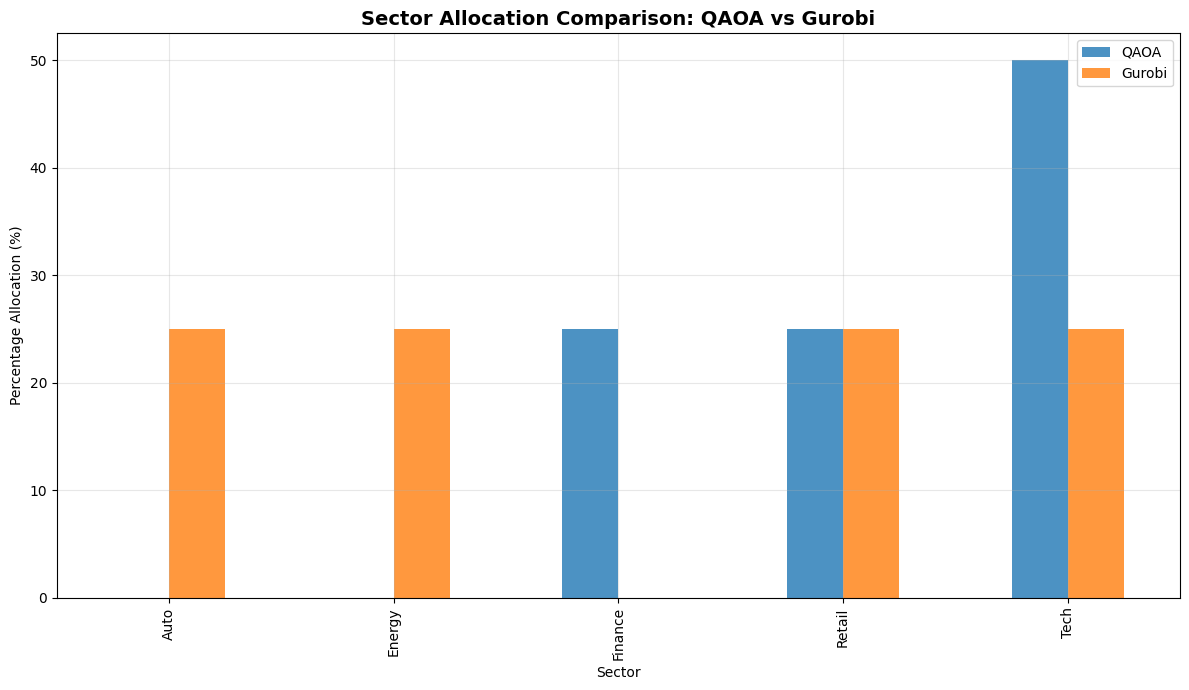

In [19]:
# Define sectors (simplified mapping for 10 tickers)
sector_map = {
    'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOG': 'Tech', 'AMZN': 'Tech', 'META': 'Tech', 'NVDA': 'Tech',
    'TSLA': 'Auto', 'JPM': 'Finance', 'WMT': 'Retail', 'XOM': 'Energy'
}

sector_names = sorted(list(set(sector_map.values())))

# Initialize data for sector distributions
sector_data = pd.DataFrame(index=sector_names)
sector_data['QAOA'] = 0
sector_data['Gurobi'] = 0

# Count sectors in QAOA selection
for t in selected_q:
    sector = sector_map.get(t, 'Other')
    sector_data.loc[sector, 'QAOA'] += 1

# Count sectors in Gurobi selection if available
if selected_g is not None:
    for t in selected_g:
        sector = sector_map.get(t, 'Other')
        sector_data.loc[sector, 'Gurobi'] += 1

# Normalize to % if desired
sector_data_percent = sector_data.divide(sector_data.sum(axis=0), axis=1) * 100

# Plot sector breakdown
fig, ax = plt.subplots(figsize=(12, 7))
sector_data_percent.plot(kind='bar', ax=ax, alpha=0.8)
ax.set_title('Sector Allocation Comparison: QAOA vs Gurobi', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage Allocation (%)')
ax.set_xlabel('Sector')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()